In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.ndimage import rotate
from pytomography.io.SPECT import simind
from torch.nn.functional import avg_pool2d
from copy import deepcopy
import numpy as np
from scipy.interpolate import bisplrep, bisplev
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from scipy.optimize import curve_fit

First lets look at the camera with no collimator
* We set flag 4 to false to remove the collimator

In [2]:
%%capture
! simind point 208keV_nocoll/fa:04

And we can open and plot:

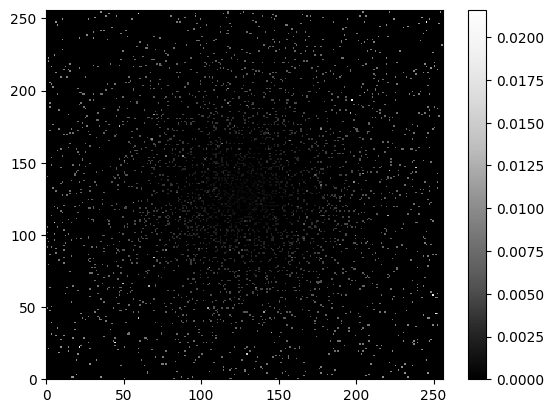

In [3]:
nocoll_E208 = simind.get_projections('208kev_nocoll_tot_w1.h00')
plt.pcolormesh(nocoll_E208[0][0].cpu(), cmap='Greys_r')
plt.colorbar()

Even though theres a point source in the center, the photons hit the camera everywhere,

We can actually control the direction of the photons by using index 19, which gives the angle of the cone by which the photons are emitted. One can simulate an ideal collimator by setting this to a very small value. 
* add `15:2/02:3/03:3/04:3` to the end to simulate a box and see that it's a perfect prediction

In [56]:
%%capture
! simind point 208keV_infinite_res/19:-0.01/fa:04

And open and plot:

In [57]:
infres_E208 = simind.get_projections('208kev_infinite_res_tot_w1.h00')

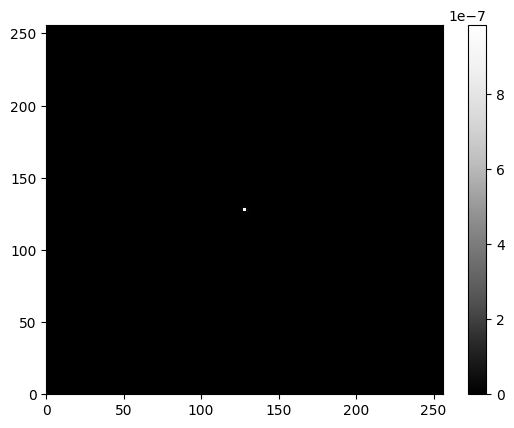

In [58]:
plt.pcolormesh(infres_E208[0][0].cpu(), cmap='Greys_r')
#plt.xlim(120,136)
#plt.ylim(120,136)
plt.colorbar()

Now all the counts are localized in the center. But we manually controlled the photon direction, enforcing that photons travel perpendicular to the detector. In practice, this is done with a collimator.

# Collimators

The main collimation routine is analytical, and is set with index 53=0. This is therefore not Monte Carlo based: but it works well enough for certain energies

* For now we'll consider 208keV photons with the Siemens medium energy collimator

In [59]:
%%capture
! simind point 208keV_collana/cc:si-me

And we can open and plot

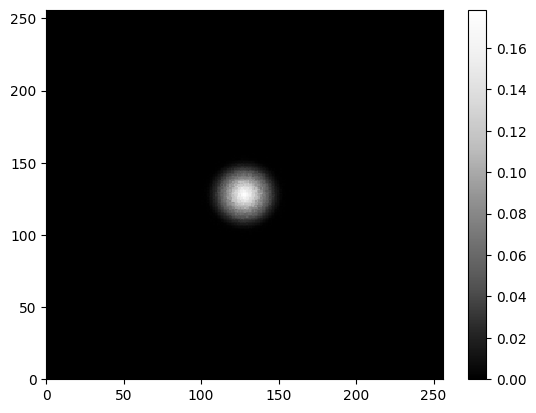

In [60]:
collana_E208 = simind.get_projections('208kev_collana_tot_w1.h00')
plt.pcolormesh(collana_E208[0][0].cpu(), cmap='Greys_r')
plt.colorbar()

# Real Collimators

The analytical routine should yield results similar to a real collimator. But a real collimator is hexagonal:

![](collimator.jpg)

We can do a simulation of the hexagonal collimator by setting index 53=1. In this case, we will choose the Siemens medium energy collimator by using the flag `cc:si-me'`

In [63]:
%%capture
! simind point 208keV_collnomovement/cc:si-me/53:1

When we look at the projections, we see that the "response" is hexagonal as we expect:

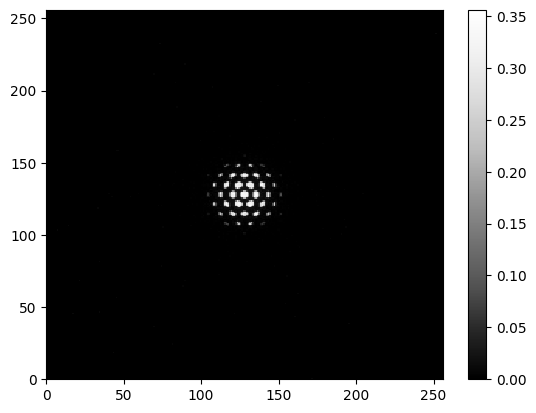

In [64]:
collnomovement_E208 = simind.get_projections('208kev_collnomovement_tot_w1.h00')
plt.pcolormesh(collnomovement_E208[0][0].cpu(), cmap='Greys_r')
plt.colorbar()

**But this doesn't look like our analytical estimate above**
* In practice, the SPECT collimator will physically move during acquisition so that all areas get exposed. We can simulate collimator movement using index 59=1

In [65]:
%%capture
! simind point 208keV_collmovement/cc:si-me/53:1/59:1

In [66]:
collmovement_E208 = simind.get_projections('208kev_collmovement_tot_w1.h00')

When we plot all three together, we see the analytical and Monte Carlo with movement correspond well with eachother!

(0.0, 256.0, 0.0, 256.0)

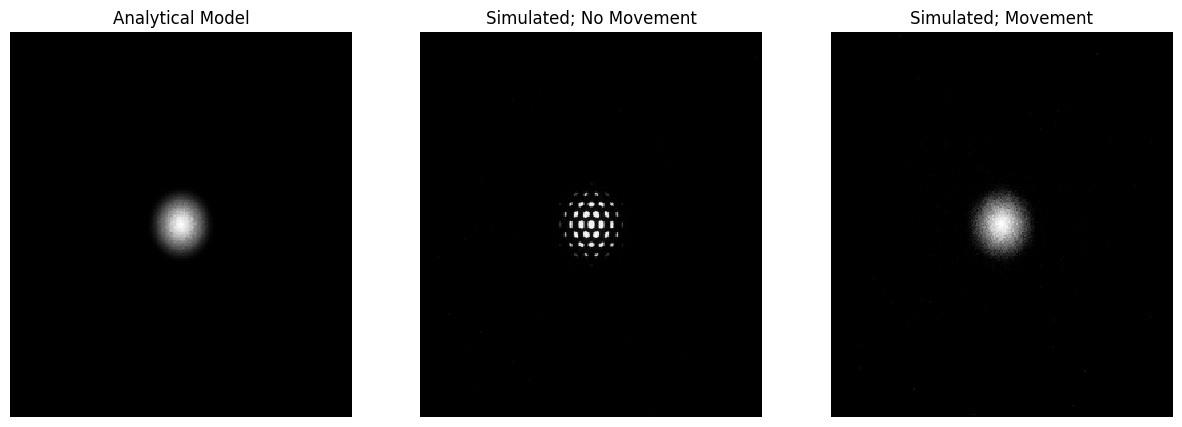

In [69]:
plt.subplots(1,3,figsize=(15,5))
plt.subplot(131)
plt.pcolormesh(collana_E208[0][0].cpu(), cmap='Greys_r')
plt.title('Analytical Model')
plt.axis('off')
plt.subplot(132)
plt.pcolormesh(collnomovement_E208[0][0].cpu(), cmap='Greys_r')
plt.title('Simulated; No Movement')
plt.axis('off')
plt.subplot(133)
plt.pcolormesh(collmovement_E208[0][0].cpu(), cmap='Greys_r')
plt.title('Simulated; Movement')
plt.axis('off')

# Fly In The Ointment

The above does NOT hold for higher energy photons which tend to penetrate the lead (the attenuating properties of lead drop by an order of magnitude across various SPECT radionnuclides). In particular, the analytical routine does not match the Monte Carlo routine with collimator movement.

* We run the same routines as above, but now with photons of energy 440keV

In [5]:
%%capture
! simind point 440keV_collana/01:440/cc:si-me
! simind point 440keV_collnomovement/01:440/cc:si-me/53:1
! simind point 440keV_collmovement/01:440/cc:si-me/53:1/59:1

When we open and plot, we can see the septal penetration thats apparent in the Monte Carlo, but not simulated in the analytical

In [6]:
collana_E440 = simind.get_projections('440kev_collana_tot_w1.h00')
collnomovement_E440 = simind.get_projections('440kev_collnomovement_tot_w1.h00')
collmovement_E440 = simind.get_projections('440kev_collmovement_tot_w1.h00')

(0.0, 256.0, 0.0, 256.0)

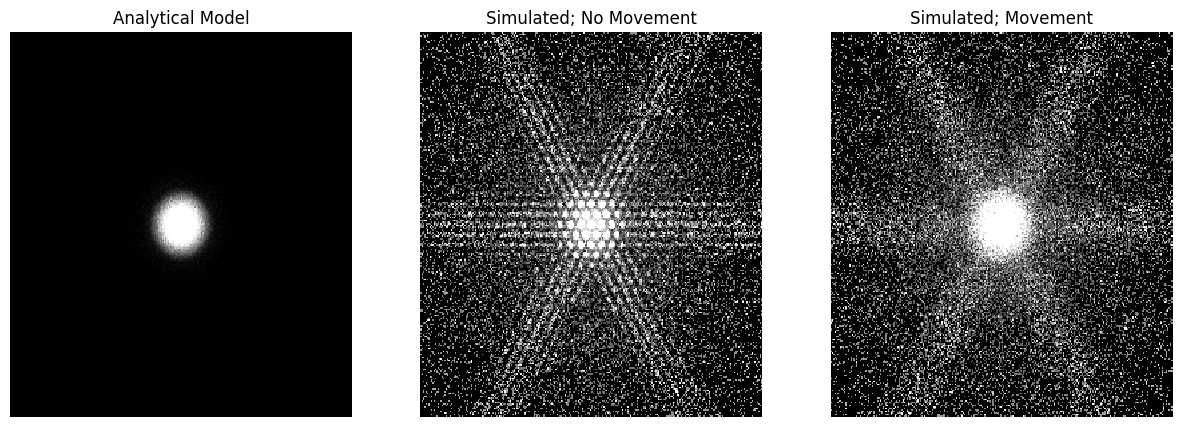

In [7]:
plt.subplots(1,3,figsize=(15,5))
plt.subplot(131)
plt.pcolormesh(collana_E440[0][0].cpu(), cmap='Greys_r', vmax=0.02)
plt.title('Analytical Model')
plt.axis('off')
plt.subplot(132)
plt.pcolormesh(collnomovement_E440[0][0].cpu(), cmap='Greys_r', vmax=0.02)
plt.title('Simulated; No Movement')
plt.axis('off')
plt.subplot(133)
plt.pcolormesh(collmovement_E440[0][0].cpu(), cmap='Greys_r', vmax=0.02)
plt.title('Simulated; Movement')
plt.axis('off')

In [8]:
collnomovement_E440.sum()

tensor(244.3306, device='cuda:0')

In [9]:
collmovement_E440.sum()

tensor(240.3651, device='cuda:0')

While a high-energy collimator can help (longer hole length/thicker septal) it doesn't completely remove these effects:

In [2]:
%%capture
! simind point 440keV_collana/01:440/cc:si-he
! simind point 440keV_collnomovement/01:440/cc:si-he/53:1/23:0.4
! simind point 440keV_collmovement/01:440/cc:si-he/53:1/59:1

Open

In [3]:
collana_E440 = simind.get_projections('440kev_collana_tot_w1.h00')
collnomovement_E440 = simind.get_projections('440kev_collnomovement_tot_w1.h00')
collmovement_E440 = simind.get_projections('440kev_collmovement_tot_w1.h00')

Plot

(0.0, 256.0, 0.0, 256.0)

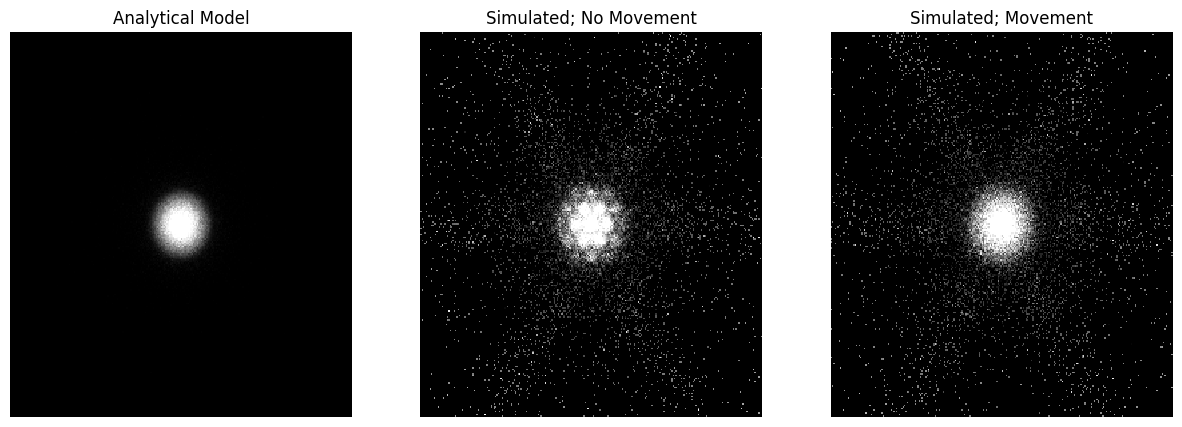

In [4]:
plt.subplots(1,3,figsize=(15,5))
plt.subplot(131)
plt.pcolormesh(collana_E440[0][0].cpu(), cmap='Greys_r', vmax=0.02)
plt.title('Analytical Model')
plt.axis('off')
plt.subplot(132)
plt.pcolormesh(collnomovement_E440[0][0].cpu(), cmap='Greys_r', vmax=0.02)
plt.title('Simulated; No Movement')
plt.axis('off')
plt.subplot(133)
plt.pcolormesh(collmovement_E440[0][0].cpu(), cmap='Greys_r', vmax=0.02)
plt.title('Simulated; Movement')
plt.axis('off')

These need to be dealt with carefully in SPECT reconstruction of high energy photons. See the following paper for more details:

* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3619230/